## Init notebook

This is run once.

## Preliminaries

In [1]:
import quantus

2023-10-02 17:49:27.829009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 17:49:28.924531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager
import warnings
import torch
import captum
import torchvision
import wandb
from tqdm import tqdm
import os
import json
import time

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/eMPRT/scripts/quantus/__init__.py
Using device: NVIDIA TITAN RTX


## Download or Load Results

In [3]:
os.environ["WANDB_API_KEY"] = "343d642ebb6021c0303b16436ddf0be59cb0696f"
wandb_projectname = "denoise-sanity-checks-3"
jsonsavepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/eMPRT-sMPRT-scores-from-wandb.json"
figurepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/figures/raw-plots-sMPRT-eMPRT"
redownload_results = True

exclude_filter = {"xai_noiselevel": [0.1, 0.05], "xai_methodname": "grad-cam"}
#exclude_filter = {"xai_methodname": "grad-cam"}

os.makedirs(figurepath, exist_ok=True)

def wandb_summary_to_dict(summary):
    """
    turns the weird nected dict-like summary data structure used by wandb into a standard nested python dict
    recursive function.
    """
    if not isinstance(summary, wandb.sdk.wandb_summary.SummaryDict) and not isinstance(summary, wandb.old.summary.SummarySubDict):
        return summary

    if "_type" in summary.keys() and "value" in summary.keys():
        return wandb_summary_to_dict(summary["value"])

    newsummary = {}
    for k, v in summary.items():
        newsummary[k] = wandb_summary_to_dict(v)

    return newsummary

def nested_config_to_flat(prefix, config, newconfig):
    """
    turns a nested config into a flat config
    """
    if not isinstance(config, dict):
        newconfig[prefix] = config
        return None

    if newconfig is None:
        newconfig = {}
        for k, v in config.items():
            nested_config_to_flat(k, v, newconfig)
        return newconfig

    else:
        for k, v in config.items():
            _ = nested_config_to_flat(f"{prefix}.{k}", v, newconfig)
        return None

# Get all results from wandb
if not os.path.exists(jsonsavepath) or redownload_results:
    print("Downloading Results from wandb...")
    scores = []
    api = wandb.Api()
    entity, project = "leanderweber", wandb_projectname  # set to your entity and project 
    runs = api.runs(entity + "/" + project) 
    with tqdm(total=len(runs)) as pbar:
        for run in runs: 
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files 
            config = {k: v for k,v in run.config.items() if not k.startswith('_')}
            if all([config[s] not in v for s, v in exclude_filter.items()]):
                summary = run.summary
                if "scores" in summary.keys():
                    dictsummary = wandb_summary_to_dict(summary["scores"])
                    newconfig = nested_config_to_flat(None, config, None)
                    scores.append((newconfig, dictsummary))

            pbar.update(1)

    with open(jsonsavepath, "w") as jsonfile:
        json.dump(scores, jsonfile)

else:
    with open(jsonsavepath, "r") as jsonfile:
        scores = json.load(jsonfile)

100%|██████████| 2354/2354 [04:55<00:00,  7.98it/s]


## Plots



In [4]:
# General Plot Config
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
plt.rcParams.update({'font.size': 15})
palette = cm.get_cmap("tab20")(np.linspace(0, 1, 20))
std_alpha = 0.2
linewidth = 2.5

# Beautification Things
LAYER_ORDER_MAP = {
    "top_down": "top-down", 
    "bottom_up": "bottom_up"
    }
METHOD_MAP = {
    "model": "Model Accuracy",
    "gradient": "Saliency",
    "gradient-noabs": "Gradient",
    "grad-cam": "GradCAM",
    "smoothgrad": "SmoothGrad",
    "intgrad": "IntGrad",
    "lrp-epsilon": r"LRP-$\varepsilon$", 
    "lrp-zplus": r"LRP-$z^+$", 
    "guided-backprop": "Guided Backprop", 
    "random": "Random Attribution"
}
COLOR_MAP = {
    "model": "black",
    "gradient": palette[1],
    "gradient-noabs": palette[2],
    "grad-cam": palette[3],
    "smoothgrad": palette[4],
    "intgrad": palette[5],
    "lrp-epsilon": palette[6],
    "lrp-zplus": palette[7],
    "guided-backprop": palette[8],
    "random": palette[9],
}
LINESTYLE_ORDER = ["dashed", "solid"]

# Setting up grouping variables etc. for plots
between_plot_filter = ["eval_layer_order", "model_name", "metric_kwargs.normalise", "xai_noiselevel"]
within_plot_filter = ["xai_methodname"]

print("Setting up filters...")
between_plot_filters = []
within_plot_filters = []
for config, _ in scores:
    duplicate = False
    for fil in between_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in between_plot_filter]):
            duplicate=True
    if not duplicate:
        between_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in between_plot_filter})

    duplicate = False
    for fil in within_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in within_plot_filter]):
            duplicate=True
    if not duplicate:
        within_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in within_plot_filter})

print(between_plot_filters)
print(within_plot_filters)

Setting up filters...
[{'eval_layer_order': 'top_down', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}, {'eval_layer_order': 'bottom_up', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}, {'eval_layer_order': 'top_down', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}, {'eval_layer_order': 'bottom_up', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}]
[{'xai_methodname': 'guided-backprop'}, {'xai_methodname': 'lrp-zplus'}, {'xai_methodname': 'lrp-epsilon'}, {'xai_methodname': 'intgrad'}, {'xai_methodname': 'smoothgrad'}, {'xai_methodname': 'gradient-noabs'}, {'xai_methodname': 'gradient'}]


/tmp/ipykernel_987770/2401426966.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab20")(np.linspace(0, 1, 20))


In [14]:
# Define functions

def filterequal(value, filtervalue):

    if isinstance(filtervalue, list):
        out = value in filtervalue
    else:
        out = value == filtervalue

    #print(value, filtervalue, out)
    return out

def select_runs(runs, filter):
    return [(c, r) for c, r in runs if all([filterequal(c[filtered_category], filter[filtered_category]) for filtered_category in filter.keys()])]

def labelsorter(label, noisedraw_vals=None):

    if noisedraw_vals is not None:
        max_noisedraw_val = np.amax(noisedraw_vals)

        for m, method in enumerate(METHOD_MAP.values()):
            if method in label:
                for noisedraw_val in noisedraw_vals:
                    if str(noisedraw_val) in label:
                        return max_noisedraw_val * m + noisedraw_val
    else:
        for m, method in enumerate(METHOD_MAP.values()):
            if method in label:
                return m

    for m, method in enumerate(METHOD_MAP.keys()):
            if method in label:
                return m

def recompute_emprt(emprt_scores, layers):
    emprt_scores_orig = np.array(emprt_scores["orig"])
    emprt_scores_last = np.array(emprt_scores[layers[-1]])

    delta = emprt_scores_last - emprt_scores_orig
    fraction = delta/emprt_scores_orig

    return [d for d in fraction]


def hamming_distance(seq1, seq2):
    return np.sum(np.abs(seq1-seq2))


def plot_mprt_lineplot(runs, measurement_name, title, ylabel, within_plot_filters, savefilename):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_title(title)
    noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs])))
    xai_methods = sorted(list(set([config["xai_methodname"] for config, _ in runs])), key=lambda z: labelsorter(z, None))

    ax.set_ylabel(ylabel)
    if ylabel == "SSIM":
        ax.set_ylim([0.0, 1.1])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1])

    model = models.get_model(runs[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]

    if "orig" in runs[0][1][measurement_name].keys():
        layers = ["orig"] + layers

    ax.set_xlabel("Layers")
    if "resnet" in runs[0][0]["model_name"]:
        ax.set_xticks(list(range(len(layers)))[::4])
        xticklabels = layers[::4]
        ax.set_xticklabels(layers[::4], rotation=45)
        markevery=4
    else:
        ax.set_xticks(list(range(len(layers)))[::2])
        xticklabels = layers[::2]
        markevery=2
    for i in range(len(xticklabels)):
        xticklabels[i] = xticklabels[i].replace("downsample", "ds")
    xticklabels = xticklabels[:-1]+["final"]
    ax.set_xticklabels(xticklabels, rotation=45)

    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs = select_runs(runs, wpf)

        noisedraw_filters = []
        for config, _ in wpf_runs:
            duplicate = False
            for fil in noisedraw_filters:
                if config["xai_n_noisedraws"] == fil["xai_n_noisedraws"]:
                    duplicate=True
            if not duplicate:
                noisedraw_filters.append({"xai_n_noisedraws": config["xai_n_noisedraws"]})

        for n, ndf in enumerate(noisedraw_filters):
            ndf_runs = select_runs(wpf_runs, ndf)

            # Sort Runs
            runs_to_plot = {l: [] for l, lay in enumerate(layers)}
            for c, r in ndf_runs:
                for l, lay in enumerate(layers):
                    if isinstance(r[measurement_name][lay][0], list):
                        for tmp in r[measurement_name][lay]:
                            runs_to_plot[l] += tmp
                    else:
                        runs_to_plot[l] += r[measurement_name][lay]

            means = np.array([np.mean(r) for l, r in runs_to_plot.items()])
            stds = np.array([np.std(r) for l, r in runs_to_plot.items()])
            delta = means[-1] - means[0]

            methodname = c["xai_methodname"]
            noisedraws = c["xai_n_noisedraws"]

            ax.plot(list(range(len(means))), means, alpha=0.7, linewidth=linewidth, marker="o", markevery=markevery, linestyle=LINESTYLE_ORDER[noisedraw_vals.index(c["xai_n_noisedraws"])], color=COLOR_MAP[methodname])
            #ax.fill_between(list(range(len(means))), means+stds, means-stds, facecolor=palette[w], alpha=std_alpha)

    # Legend
    leg_lines = []
    for n in noisedraw_vals:
        label = f"N={n}"
        leg_lines.append(ax.plot([], [], color="black", alpha=0.7, linewidth=linewidth, label=label, linestyle=LINESTYLE_ORDER[noisedraw_vals.index(n)]))
    for m in xai_methods:
        label=f"{METHOD_MAP[m]}"
        leg_lines.append(ax.plot([], [], color=COLOR_MAP[m], marker="o", alpha=0.7, linewidth=linewidth, label=label, linestyle=LINESTYLE_ORDER[noisedraw_vals.index(n)]))

    #handles, labels = plt.gca().get_legend_handles_labels()
    #print(labels)
    #ordered = sorted(list(zip(handles, labels)), key=lambda z: labelsorter(z[1], noisedraw_vals)) #Sort labels in correct order
    #plt.legend([o[0] for o in ordered], [o[1] for o in ordered])

    plt.legend()

    #plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

def plot_layerorder_lineplot(runs, title, ylabel, within_plot_filters, savefilename):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_title(title)

    ax.set_ylabel(ylabel)
    if ylabel == "SSIM":
        ax.set_ylim([0.0, 1.1])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1])

    model = models.get_model(runs[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]

    layers = ["orig"] + layers

    ax.set_xlabel("Layers")
    if "resnet" in runs[0][0]["model_name"]:
        ax.set_xticks(list(range(len(layers)))[::4])
        xticklabels = layers[::4]
        ax.set_xticklabels(layers[::4], rotation=45)
        markevery=4
    else:
        ax.set_xticks(list(range(len(layers)))[::2])
        xticklabels = layers[::2]
        markevery=2
    for i in range(len(xticklabels)):
        xticklabels[i] = xticklabels[i].replace("downsample", "ds")
    xticklabels = xticklabels[:-1]+["final"]
    ax.set_xticklabels(xticklabels, rotation=45)

    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs = select_runs(runs, wpf)

        evalmetric_filters = []
        for config, _ in wpf_runs:
            duplicate = False
            for fil in evalmetric_filters:
                if config["eval_metricname"] == fil["eval_metricname"]:
                    duplicate=True
            if not duplicate:
                evalmetric_filters.append({"eval_metricname": config["eval_metricname"]})

        for n, ndf in enumerate(evalmetric_filters):
            ndf_runs = select_runs(wpf_runs, ndf)

            # Sort Runs
            runs_to_plot = {l: [] for l, lay in enumerate(layers)}
            for c, r in ndf_runs:
                for l, lay in enumerate(layers):
                    if c["eval_metricname"] == "model":
                        runs_to_plot[l] = r["accuracy"][lay]
                    elif isinstance(r["explanation_scores"][lay][0], list):
                        for tmp in r["explanation_scores"][lay]:
                            runs_to_plot[l] += tmp
                    else:
                        runs_to_plot[l] += r["explanation_scores"][lay]

            means = np.array([np.mean(r) for l, r in runs_to_plot.items()])
            stds = np.array([np.std(r) for l, r in runs_to_plot.items()])
            delta = means[-1] - means[0]

            methodname = c["xai_methodname"]
            noisedraws = c["xai_n_noisedraws"]
            metricname = c["eval_metricname"]

            if metricname == "model":
                label = r"{}".format(METHOD_MAP[metricname])
                color=COLOR_MAP[metricname]
            else:
                label = r"{}".format(METHOD_MAP[methodname])
                color=COLOR_MAP[methodname]
            ax.plot(list(range(len(means))), means, alpha=0.7, linewidth=linewidth, marker="o", markevery=markevery, color=color, label=label)
            ax.fill_between(list(range(len(means))), means+stds, means-stds, facecolor=color, alpha=std_alpha)

    handles, labels = plt.gca().get_legend_handles_labels()
    print(labels)
    ordered = sorted(list(zip(handles, labels)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered], [o[1] for o in ordered])
    #plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

def plot_n_xaidraws_plot(runs1, measurement_name1, title, ylabel1, within_plot_filters, savefilename):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

    ax1.set_title(title)

    noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs1])))
    ax1.set_xlabel("N")
    #ax1.set_xticks(list(range(len(layers))))
    #ax1.set_xticklabels(layers)

    ax1.set_ylabel(ylabel1)
    if ylabel1 == "SSIM":
        ax1.set_ylim([0.0, 1.1])
        ax1.set_yticks([0, 0.5, 1.0])
        ax1.set_yticklabels([0, 0.5, 1])

    ax1.set_xlim((1, 300))

    model = models.get_model(runs1[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs1[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]
    if "orig" in runs1[0][1][measurement_name1].keys():
        layers = ["orig"] + layers

    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs1 = select_runs(runs1, wpf)

        if len(wpf_runs1) == 0:
            continue

        noisedraw_vals = sorted(list(set([c["xai_n_noisedraws"] for c, m  in wpf_runs1])))
        runs_to_plot1 = {nd: {l: [] for l in layers} for nd in noisedraw_vals}
        for c, r in wpf_runs1:
            nd = c["xai_n_noisedraws"]
            if measurement_name1 == "explanation_scores":
                for l in layers:
                    if isinstance(r[measurement_name1][l][0], list):
                        runs_to_plot1[nd][l] += r[measurement_name1][l][0]
                    else:
                        runs_to_plot1[nd][l] += r[measurement_name1][l]
            else:
                raise ValueError


        plotvals = []
        for nd, nd_val in runs_to_plot1.items():
            l_means = []
            for l, l_val in nd_val.items():
                l_means.append(np.mean(l_val))
            plotvals.append(np.trapz(l_means))

        methodname = c["xai_methodname"]

        ax1.plot(noisedraw_vals, plotvals, alpha=0.7, linewidth=linewidth*2, marker="o", color=COLOR_MAP[methodname], label=r"{}".format(METHOD_MAP[methodname]))
        #ax1.fill_between(noisedraw_vals, means1+stds1, means1-stds1, facecolor=COLOR_MAP[methodname], alpha=std_alpha)

    handles1, labels1 = ax1.get_legend_handles_labels()
    ordered1 = sorted(list(zip(handles1, labels1)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered1], [o[1] for o in ordered1])
    #plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

# def plot_n_xaidraws_plot(runs1, measurement_name1, title, ylabel1, within_plot_filters, savefilename):
#     fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

#     ax1.set_title(title)

#     noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs1])))
#     ax1.set_xlabel("# Noise Samples")
#     #ax1.set_xticks(list(range(len(layers))))
#     #ax1.set_xticklabels(layers)

#     ax1.set_ylabel(ylabel1)
#     if ylabel1 == "SSIM":
#         ax1.set_ylim([0.0, 1.1])
#         ax1.set_yticks([0, 0.5, 1.0])
#         ax1.set_yticklabels([0, 0.5, 1])

#     ax1.set_xlim((1, 500))

#     model = models.get_model(runs1[0][0]["model_name"], device)
#     layers = [
#         l[0]
#         for l in model.named_modules()
#         if (hasattr(l[1], "reset_parameters"))
#     ]
#     if runs1[0][0]['eval_layer_order'] == "top_down":
#         layers = layers[::-1]
#     if "orig" in runs1[0][1][measurement_name1].keys():
#         layers = ["orig"] + layers

    
#     for w, wpf in enumerate(within_plot_filters):
        
#         wpf_runs1 = select_runs(runs1, wpf)

#         if len(wpf_runs1) == 0:
#             continue

#         noisedraw_vals = sorted(list(set([c["xai_n_noisedraws"] for c, m  in wpf_runs1])))
#         runs_to_plot1 = {nd: [] for nd in noisedraw_vals}
#         for c, r in wpf_runs1:
#             nd = c["xai_n_noisedraws"]
#             if measurement_name1 == "explanation_scores":
#                 if isinstance(r[measurement_name1][layers[-1]][0], list):
#                     for tmp in r[measurement_name1][layers[-1]]:
#                         runs_to_plot1[nd] += tmp
#                 else:
#                     runs_to_plot1[nd] += r[measurement_name1][layers[-1]]
#             else:
#                 runs_to_plot1[nd] += r[measurement_name1]

#         means1 = np.array([np.mean(r) for l, r in runs_to_plot1.items()])
#         stds1 = np.array([np.std(r) for l, r in runs_to_plot1.items()])

#         methodname = c["xai_methodname"]

#         ax1.plot(noisedraw_vals, means1, alpha=1.0, linewidth=linewidth, marker=".", color=COLOR_MAP[methodname], label=r"{} ({})".format(METHOD_MAP[methodname], ylabel1))
#         ax1.fill_between(noisedraw_vals, means1+stds1, means1-stds1, facecolor=COLOR_MAP[methodname], alpha=std_alpha)

#     handles1, labels1 = ax1.get_legend_handles_labels()
#     ordered1 = sorted(list(zip(handles1, labels1)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
#     plt.legend([o[0] for o in ordered1], [o[1] for o in ordered1])
#     #plt.tight_layout()
#     plt.grid(True)

#     fig.savefig(savefilename)
#     plt.show()

def plot_rankingchange_plot(runs1, measurement_name1, title, sortascending, within_plot_filters, savefilename):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))

    ax1.set_title(title)

    noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs1])))
    xai_methods = sorted(list(set([config["xai_methodname"] for config, _ in runs1])))
    ax1.set_xlabel("# Noise Samples")
    ax1.set_xticks(noisedraw_vals)

    ax1.set_ylabel("Ranking")
    ax1.set_yticks(list(range(len(xai_methods))))

    model = models.get_model(runs1[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs1[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]
    if "orig" in runs1[0][1]["explanation_scores"].keys():
        layers = ["orig"] + layers

    collected_means = {nd: {} for nd in noisedraw_vals}
    rankings = {m: [] for m in xai_methods}
    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs1 = select_runs(runs1, wpf)

        if len(wpf_runs1) == 0:
            continue

        noisedraw_vals = sorted(list(set([c["xai_n_noisedraws"] for c, m  in wpf_runs1])))
        for c, r in wpf_runs1:
            nd = c["xai_n_noisedraws"]
            methodname = c["xai_methodname"]
            if methodname not in collected_means[nd].keys():
                collected_means[nd][methodname] = []
            if measurement_name1 == "explanation_scores":
                if isinstance(r[measurement_name1][layers[1]][0], list):
                    for tmp in r[measurement_name1][layers[1]]:
                        collected_means[nd][methodname] += tmp
                else:
                    collected_means[nd][methodname] += r[measurement_name1][layers[1]]
            else:
                collected_means[nd][methodname] += r[measurement_name1]


    for nd, m_vals in collected_means.items():
        means = []
        for m in m_vals.keys():
            means.append(np.mean(collected_means[nd][m]))
        sorting = np.argsort(means)
        if not sortascending:
            sorting = sorting[::-1]
        methods = list(m_vals.keys())
        for i, s in enumerate(sorting):
            rankings[methods[s]].append(i)

    for method, values in rankings.items():
        ax1.plot(noisedraw_vals, values, alpha=1.0, linewidth=linewidth*3, marker="", color=COLOR_MAP[method], label=r"{}".format(METHOD_MAP[method]))

    handles1, labels1 = ax1.get_legend_handles_labels()
    ordered1 = sorted(list(zip(handles1, labels1)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered1], [o[1] for o in ordered1])
    #plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

def plot_rankingchange_barplot(runs1, within_plot_filters, savefilename):
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

    noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs1])))
    xai_methods = sorted(list(set([config["xai_methodname"] for config, _ in runs1])))
    eval_metrics = sorted(list(set([config["eval_metricname"] for config, _ in runs1])))

    ax1.set_ylabel("Avg. Distance")
    ax1.set_ylim(-0.1, len(xai_methods))
    #ax1.set_yticks([0, 1.0])

    model = models.get_model(runs1[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs1[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]
    if "orig" in runs1[0][1]["explanation_scores"].keys():
        layers = ["orig"] + layers

    collected_means = {nd: {} for nd in noisedraw_vals}
    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs1 = select_runs(runs1, wpf)

        if len(wpf_runs1) == 0:
            continue

        noisedraw_vals = sorted(list(set([c["xai_n_noisedraws"] for c, m  in wpf_runs1])))
        for c, r in wpf_runs1:
            nd = c["xai_n_noisedraws"]
            methodname = c["xai_methodname"]
            metricname = c["eval_metricname"]
            if metricname not in collected_means[nd].keys():
                collected_means[nd][metricname] = {}
            if methodname not in collected_means[nd][metricname].keys():
                collected_means[nd][metricname][methodname] = {}

            if metricname == "emprt":
                for layer in layers:
                    if layer not in collected_means[nd][metricname][methodname].keys():
                        collected_means[nd][metricname][methodname][layer] = []
                    collected_means[nd][metricname][methodname][layer] += recompute_emprt(r["explanation_scores"], layers)
            else:
                for layer in layers:
                    if layer not in collected_means[nd][metricname][methodname].keys():
                        collected_means[nd][metricname][methodname][layer] = []

                    if isinstance(r["explanation_scores"][layer], list):
                        for tmp in r["explanation_scores"][layer]:
                            collected_means[nd][metricname][methodname][layer] += [tmp]
                    else:
                        collected_means[nd][metricname][methodname][layer] += r["explanation_scores"][layer]

    rankings = {e: {m: {l: [] for l in layers} for m in xai_methods} for e in eval_metrics}
    for nd, nd_vals in collected_means.items():
        for metr, metr_vals in nd_vals.items():
            means = {l: [] for l in layers}
            for meth, meth_vals in metr_vals.items():
                for layer, lay_val in meth_vals.items():
                    means[layer].append(np.mean(lay_val))


            for layer in layers:
                sorting = np.argsort(means[layer])
                methods = list(metr_vals.keys())
                for i, s in enumerate(sorting):
                    rankings[metr][methods[s]][layer].append(i)

    xticklabels = []
    for a, (metr, metr_vals) in enumerate(rankings.items()):
        xticklabels += [metr]
        b=0
        for meth in COLOR_MAP.keys():
            if meth in metr_vals.keys():
                meth_vals = metr_vals[meth]
                pairwise_hammings = []
                for layer, lay_vals in meth_vals.items():
                    pairwise_hammings.append([hamming_distance(lay_vals[i], lay_vals[i+1]) for i in range(len(lay_vals)-1)])

                xloc = a * (len(metr_vals.keys())+1)+b
                ax1.bar(xloc, np.mean(pairwise_hammings)+0.1, bottom=-0.1, width=1, color=COLOR_MAP[meth], label=r"{}".format(METHOD_MAP[meth]))
                
                if b != 0:
                    xticklabels += [""]

                #print(xloc, metr, meth, pairwise_hammings, xticklabels)
                b+=1

    ax1.set_xticks(range(len(xticklabels[:-1])))
    ax1.set_xticklabels(xticklabels[:-1])

    handles1, labels1 = ax1.get_legend_handles_labels()
    ordered1 = sorted(list(zip(handles1, labels1)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered1][::2], [o[1] for o in ordered1[::2]])
    #plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

def plot_twinplot(runs1, runs2, measurement_name1, measurement_name2, title, ylabel1, ylabel2, within_plot_filters, savefilename):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

    ax1.set_title(title)

    noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs1])))
    ax1.set_xlabel("# Noise Samples")
    #ax1.set_xticks(list(range(len(layers))))
    #ax1.set_xticklabels(layers)

    ax2 = ax1.twinx()

    ax1.set_ylabel(ylabel1)
    if ylabel1 == "SSIM":
        ax1.set_ylim([0.0, 1.1])
        ax1.set_yticks([0, 0.5, 1.0])
        ax1.set_yticklabels([0, 0.5, 1])

    ax2.set_ylabel(ylabel2)
    if ylabel2 == "SSIM":
        ax2.set_ylim([0.0, 1.1])
        ax2.set_yticks([0, 0.5, 1.0])
        ax2.set_yticklabels([0, 0.5, 1])

    model = models.get_model(runs1[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs1[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]
    if "orig" in runs1[0][1][measurement_name1].keys():
        layers = ["orig"] + layers

    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs1 = select_runs(runs1, wpf)
        wpf_runs2 = select_runs(runs2, wpf)

        if len(wpf_runs1) == 0 or len(wpf_runs2) == 0:
            continue

        noisedraw_vals = sorted(list(set([c["xai_n_noisedraws"] for c, m  in wpf_runs1])))
        runs_to_plot1 = {nd: [] for nd in noisedraw_vals}
        for c, r in wpf_runs1:
            nd = c["xai_n_noisedraws"]
            if measurement_name1 == "explanation_scores":
                if isinstance(r[measurement_name1][layers[-1]][0], list):
                    for tmp in r[measurement_name1][layers[-1]]:
                        runs_to_plot1[nd] += tmp
                else:
                    runs_to_plot1[nd] += r[measurement_name1][layers[-1]]
            else:
                runs_to_plot1[nd] += r[measurement_name1]

                runs_to_plot1 = {nd: [] for nd in noisedraw_vals}

        runs_to_plot2 = {nd: [] for nd in noisedraw_vals}
        for c, r in wpf_runs2:
            nd = c["xai_n_noisedraws"]
            if measurement_name2 == "explanation_scores":
                if isinstance(r[measurement_name2][layers[-1]][0], list):
                    for tmp in r[measurement_name2][layers[-1]]:
                        runs_to_plot2[nd] += tmp
                else:
                    runs_to_plot2[nd] += r[measurement_name2][layers[-1]]
            else:
                # if isinstance(r["explanation_scores"][layers[0]][0], list):
                #     tmp = r["explanation_scores"][layers[0]][0]
                # else:
                #     tmp = r["explanation_scores"][layers[0]]
                # runs_to_plot2[nd] += [a/b for a, b in list(zip(r[measurement_name2], tmp))]
                runs_to_plot2[nd] += r[measurement_name2]

        means1 = np.array([np.mean(r) for l, r in runs_to_plot1.items()])
        stds1 = np.array([np.std(r) for l, r in runs_to_plot1.items()])
        means2 = np.array([np.mean(r) for l, r in runs_to_plot2.items()])
        stds2 = np.array([np.std(r) for l, r in runs_to_plot2.items()])

        methodname = c["xai_methodname"]

        ax1.plot(noisedraw_vals, means1, alpha=1.0, linewidth=linewidth, marker=".", color=COLOR_MAP[methodname], label=r"{} ({})".format(METHOD_MAP[methodname], ylabel1))
        ax1.fill_between(noisedraw_vals, means1+stds1, means1-stds1, facecolor=COLOR_MAP[methodname], alpha=std_alpha)
        ax2.plot(noisedraw_vals, means2, alpha=1.0, linewidth=linewidth, marker="d", color=COLOR_MAP[methodname], label=r"{} ({})".format(METHOD_MAP[methodname], ylabel2))
        ax2.fill_between(noisedraw_vals, means2+stds2, means2-stds2, facecolor=COLOR_MAP[methodname], alpha=std_alpha)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ordered1 = sorted(list(zip(handles1, labels1)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    ordered2 = sorted(list(zip(handles2, labels2)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered1]+[o[0] for o in ordered2], [o[1] for o in ordered1]+[o[1] for o in ordered2])
    #plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

### sMPRT - Line Plots

28
{'eval_layer_order': 'top_down', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}
{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


/tmp/ipykernel_365163/632699856.py:50: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


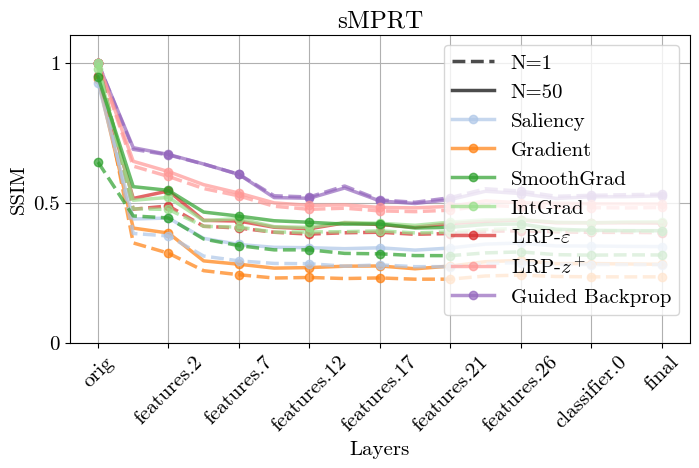

{'eval_layer_order': 'top_down', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}
{'eval_layer_order': 'bottom_up', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


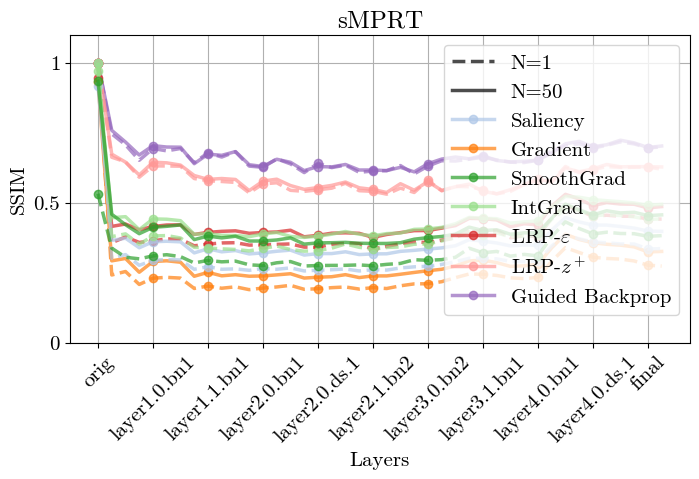

In [58]:
selection_filters = [{"eval_metricname": "smprt", "metric_kwargs.normalise": True, "eval_layer_order": "bottom_up"}]


plotted_xai_n_noisedraws = [1, 50]

# Iterate through filters
for selection_filter in selection_filters:

    selected_runs = select_runs(scores, selection_filter)

    selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]

    print(len(selected_runs))

    for bpf in between_plot_filters:
        bpf_runs = select_runs(selected_runs, bpf)
        print(bpf)

        if len(bpf_runs) == 0:
            continue

        fname = f"smprt-lineplot-imagenet"
        for k, v in bpf.items():
            fname += f"-{v}"
        filepath = os.path.join(figurepath, fname+".svg")
        plot_mprt_lineplot(bpf_runs, "explanation_scores", "sMPRT", "SSIM", within_plot_filters, filepath)


In [7]:
# selection_filters = [{"eval_metricname": ["smprt", "model"], "metric_kwargs.normalise": True, "xai_noiselevel": 0.01}]
# plotted_xai_n_noisedraws = [1]

# # Iterate through filters
# for selection_filter in selection_filters:
#     selected_runs = select_runs(scores, selection_filter)
#     selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]
#     for bpf in between_plot_filters:
#         bpf_runs = select_runs(selected_runs, bpf)

#         print(bpf)
#         fname = f"smprt-lineplot-layerorder-imagenet"
#         for k, v in bpf.items():
#             fname += f"-{v}"
#         filepath = os.path.join(figurepath, fname+".svg")
#         plot_layerorder_lineplot(bpf_runs, "sMPRT", "SSIM / Accuracy", within_plot_filters, filepath)

{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


/tmp/ipykernel_987770/1666220293.py:240: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))


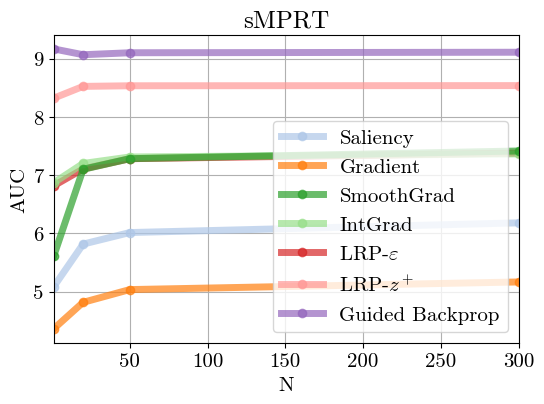

{'eval_layer_order': 'bottom_up', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


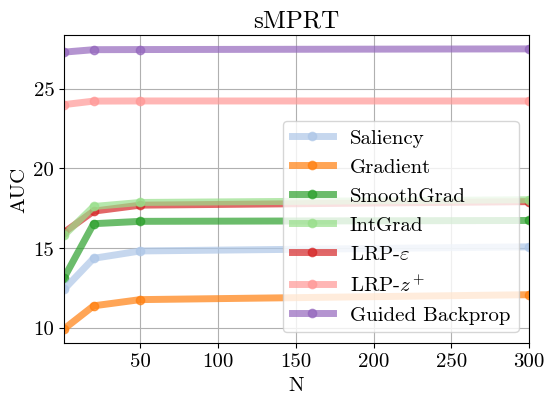

In [15]:
selection_filters = [{"eval_metricname": "smprt", "metric_kwargs.normalise": True, "eval_layer_order": "bottom_up"}]

# Iterate through filters
for selection_filter in selection_filters:
    selected_runs = select_runs(scores, selection_filter)
    for bpf in between_plot_filters:
        bpf_runs = select_runs(selected_runs, bpf)

        if len(bpf_runs) == 0:
            continue
    
        print(bpf)
        fname = f"smprt-lineplot-n-xaidraws-imagenet"
        for k, v in bpf.items():
            fname += f"-{v}"
        filepath = os.path.join(figurepath, fname+".svg")
        plot_n_xaidraws_plot(bpf_runs, "explanation_scores", "sMPRT", "AUC", within_plot_filters, filepath)

### eMPRT - Line Plots

In [9]:
# selection_filters = [{"eval_metricname": "emprt"}]
# plotted_xai_n_noisedraws = [1, 300]

# # Iterate through filters
# for selection_filter in selection_filters:
#     selected_runs = select_runs(scores, selection_filter)
#     selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]
#     for bpf in between_plot_filters:
#         bpf_runs = select_runs(selected_runs, bpf)

#         print(bpf)
#         fname = f"emprt-lineplot-imagenet"
#         for k, v in bpf.items():
#             fname += f"-{v}"
#         filepath = os.path.join(figurepath, fname+".svg")
#         plot_mprt_lineplot(bpf_runs, "explanation_scores", "eMPRT", "Complexity", within_plot_filters, filepath)

### sMPRT - NoiseRanking Change

{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


/tmp/ipykernel_835696/497589288.py:361: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))


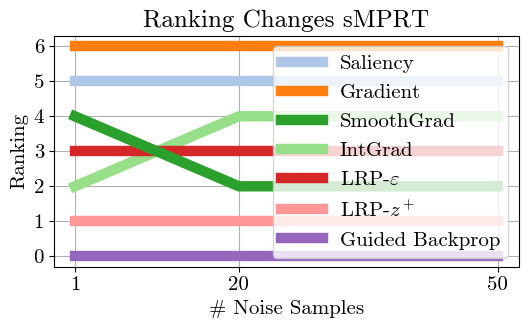

{'eval_layer_order': 'bottom_up', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


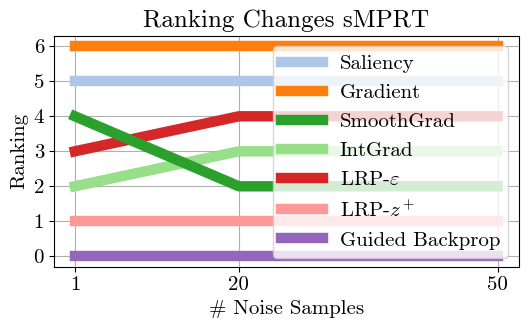

In [15]:
selection_filter = {"eval_metricname": "smprt", "metric_kwargs.normalise": True, "eval_layer_order": "bottom_up"}
plotted_xai_methods = METHOD_MAP.keys()
plotted_xai_n_noisedraws = [1, 20, 50]

# Iterate through filters
selected_runs = select_runs(scores, selection_filter)
selected_runs = [(c, r) for c, r in selected_runs if c["xai_methodname"] in plotted_xai_methods]
selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]

for bpf in between_plot_filters:
    bpf_runs = select_runs(selected_runs, bpf)  
    if len(bpf_runs) == 0:
        continue

    print(bpf)
    fname = f"smprt-rankingchange-imagenet"
    for k, v in bpf.items():
        fname += f"-{v}"
    filepath = os.path.join(figurepath, fname+".svg")
    plot_rankingchange_plot(bpf_runs, "explanation_scores", "Ranking Changes sMPRT", False, within_plot_filters, filepath)

### eMPRT - NoiseRanking Change

{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


/tmp/ipykernel_835696/497589288.py:361: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))


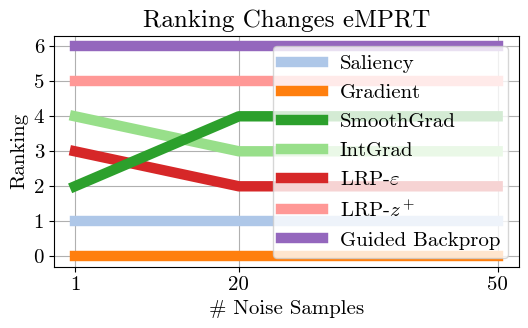

{'eval_layer_order': 'bottom_up', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


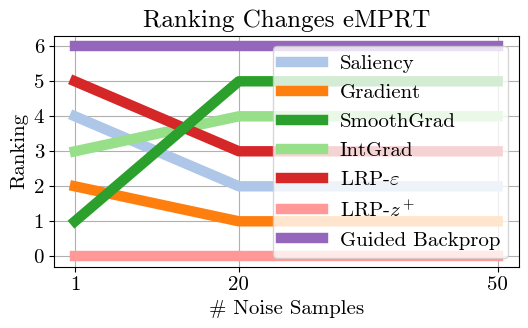

In [14]:
selection_filter = {"eval_metricname": "emprt", "metric_kwargs.normalise": True, "eval_layer_order": "bottom_up"}
plotted_xai_methods = METHOD_MAP.keys()
plotted_xai_n_noisedraws = [1, 20, 50]


# Iterate through filters
selected_runs = select_runs(scores, selection_filter)
selected_runs = [(c, r) for c, r in selected_runs if c["xai_methodname"] in plotted_xai_methods]
selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]

for bpf in between_plot_filters:
    bpf_runs = select_runs(selected_runs, bpf)
    if len(bpf_runs) == 0:
        continue

    print(bpf)
    fname = f"emprt-rankingchange-imagenet"
    for k, v in bpf.items():
        fname += f"-{v}"
    filepath = os.path.join(figurepath, fname+".svg")
    plot_rankingchange_plot(bpf_runs, "explanation_scores", "Ranking Changes eMPRT", True, within_plot_filters, filepath)

### MPRT vs. eMPRT - NoiseRanking Change

{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


/tmp/ipykernel_835696/497589288.py:433: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))


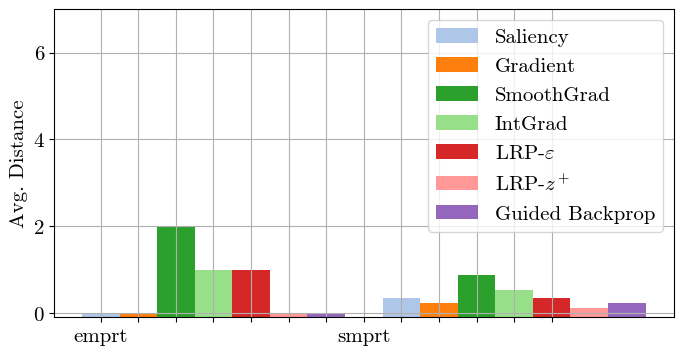

{'eval_layer_order': 'bottom_up', 'model_name': 'resnet18', 'metric_kwargs.normalise': True, 'xai_noiselevel': 0.01}


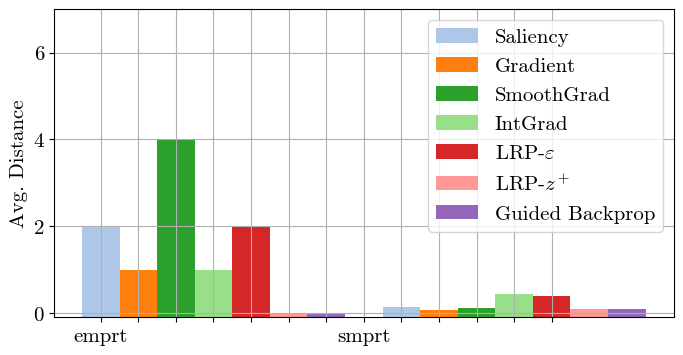

In [16]:
selection_filter = {"metric_kwargs.normalise": True, "eval_metricname": ["smprt", "emprt"], "xai_noiselevel": 0.01, "eval_layer_order": "bottom_up"}
within_plot_filters = ["xai_methodname", "eval_metricname"]
plotted_xai_n_noisedraws = [1, 50]
plotted_xai_methods = METHOD_MAP.keys()

within_plot_filters = []
for config, _ in scores:
    duplicate = False
    for fil in within_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in within_plot_filter]):
            duplicate=True
    if not duplicate:
        within_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in within_plot_filter})

# Iterate through filters
selected_runs = select_runs(scores, selection_filter)
selected_runs = [(c, r) for c, r in selected_runs if c["xai_methodname"] in plotted_xai_methods]
selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]

for bpf in between_plot_filters:
    bpf_runs = select_runs(selected_runs, bpf)  
    if len(bpf_runs) == 0:
        continue

    print(bpf)
    fname = f"smprt-rankingchange-imagenet"
    for k, v in bpf.items():
        fname += f"-{v}"
    filepath = os.path.join(figurepath, fname+".svg")
    plot_rankingchange_barplot(bpf_runs, within_plot_filters, filepath)

### sMPRT vs. eMPRT - Twin Plots

In [ ]:

# selection_filters = [{"eval_metricname": "smprt"}, {"eval_metricname": "emprt"}]
# #plotted_xai_methods = ["gradient", "lrp-zplus"]
# plotted_xai_methods = ["lrp-epsilon", "guided-backprop"]

# # Iterate through filters
# selected_runs = [select_runs(scores, selection_filter) for selection_filter in selection_filters]
# selected_runs = [[(c, r) for c, r in selected_run if c["xai_methodname"] in plotted_xai_methods] for selected_run in selected_runs]

# for bpf in between_plot_filters:
#     bpf_runs = [select_runs(selected_run, bpf) for selected_run in selected_runs]

#     print(bpf)
#     fname = f"smprt-emprt-twinplot-imagenet"
#     for k, v in bpf.items():
#         fname += f"-{v}"
#     filepath = os.path.join(figurepath, fname+".svg")
#     plot_twinplot(bpf_runs[0], bpf_runs[1], "explanation_scores", "fraction_explanation_scores", "Shattering Noise Sensitivity sMPRT vs. eMPRT", "SSIM", "eMPRT", within_plot_filters, filepath)